# DCGAN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer

## Download & Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Function Implement

In [4]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [5]:
def fully_connected_layer(x, output_size, initializer=tf.truncated_normal_initializer(stddev=1e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    w = tf.get_variable(name + '_weight', [x.get_shape()[1], output_size], initializer=initializer)
    b = tf.get_variable(name + '_bias', [output_size], initializer=initializer, dtype=tf.float32)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization)
    
    return activation(l, name=name + '_layer_' + activation.__name__), l, w, b

In [6]:
def conv_2d(x, kernel_size, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.truncated_normal_initializer(stddev=1e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = int(x.get_shape()[-1])

    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-1], initializer=initializer)
    c = tf.nn.conv2d(x, w, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_layer_batch_norm')
    
    return activation(l, name=name + '_layer_' + activation.__name__), l, w, b

In [7]:
def deconv_2d(x, kernel_size, output_shape, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.truncated_normal_initializer(stddev=1e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = output_shape[-1]
    if kernel_size[3] == -1: kernel_size[3] = int(x.get_shape()[-1])
    
    if type(output_shape) == tuple: output_shape = list(output_shape)
    if output_shape[0] == -1: output_shape[0] = tf.shape(x)[0]
    
    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-2], initializer=initializer)
    c = tf.nn.conv2d_transpose(x, w, output_shape=output_shape, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization)
    
    return activation(l, name=name + '_layer_' + activation.__name__), l, w, b

### Model Maker Class

In [8]:
class ModelMaker(object):
    def __init__(self, layers_shape):
        self.layers_shape = layers_shape
        
    def __call__(self, x, name, dropout_list=None, reuse=False):
        parameters = set()
        layers = set()
        
        last_layer = x
        
        dropout = None
                
        # scope set
        with tf.variable_scope(name, reuse=reuse) as scope:
            # create layers
            for i, (layer_type, *layer_shape) in enumerate(self.layers_shape):
                
                '''
                create matching layer
                
                c2l  : Convolutional 2 Dimention Layer
                dc2l : Deconvolutional 2 Dimention Layer
                fcl  : Fully Connected Layer(Dense) Layer
                mpl  : Max Pooling Layer
                rs   : Reshape
                flat : Flatten
                '''
                if layer_type == 'c2l': # Convolutional 2D Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = conv_2d(x=last_layer, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'dc2l': # Deconvolutional 2D Layer
                    kernel_shape, output_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = deconv_2d(x=last_layer, output_shape=output_shape, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'fcl': # Fully Connected Layer
                    output_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = fully_connected_layer(x=last_layer, \
                                                output_size=output_shape, name=str(i) + '_fc', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'mpl': # Max Pooling Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer = tf.nn.max_pool(input=x, ksize=kernel_shape, strides=stride_shape, \
                                    name=str(i) + '_mp_layer', **parmas)
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'rs': # Reshape Layer
                    reshape = layer_shape[0]
                    last_layer = tf.reshape(last_layer, reshape, name=str(i) + '_reshape')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'flat': # Flat
                    try:
                        flat_size = int(np.prod(last_layer.get_shape()[1:]))
                    except:
                        flat_size = tf.reduce_prod(tf.shape(last_layer)[1:])
                        
                    last_layer = tf.reshape(last_layer, (-1, flat_size), name=str(i) + '_flat')
                    
                    layers.add(last_layer)
                    
                # Dropout Layer
                if type(dropout) == int: # var is index
                    last_layer = tf.nn.dropout(last_layer, dropout_list[dropout], name=str(i) + '_dropout')
                    layers.add(last_layer)
                elif type(dropout) == float: # var is constant value
                    last_layer = tf.nn.dropout(last_layer, dropout, name=str(i) + '_dropout')
                    layers.add(last_layer)
                    
                
                # initialize vars
                layer_shape = \
                kernel_shape = \
                stride_shape = \
                dropout = \
                params = None
                    
            return last_layer, layers, parameters

## Util Function Implment

In [9]:
# 1-dimention Array to Image, ex) [784] array -> [28, 28] image
from PIL import Image
def ArrayToImage(arr):
    # 1-dimention array to 2-dimention
    size = np.sqrt(arr.shape[0]).astype(int)
    arr = arr.reshape(size, size)
    
    # array to image
    img = Image.fromarray(np.uint8(arr))
    return img

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

# image list display function for 'Jupytor notebook'
def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

In [10]:
# one-hot encoder
from sklearn.preprocessing import LabelBinarizer
def OneHotEncoder(label_size):
    lb = LabelBinarizer()
    lb.fit(range(label_size))
    return lb

# Network Options

In [11]:
label_size = 10 # mnist [0-9]
image_size = 784 # mnist [28, 28]
image_width = 28
image_height = 28
image_depth = 1

# z: latent random variable
z_var = 100
z_category = label_size
z_weight = 2
z = z_var + z_category + z_weight

In [12]:
generator_layer_shape=(    
    ('fcl', 7 * 7 * 64, None, {'batch_normalization': {'momentum': 0.9, 'epsilon': 1e-4}, 'activation': tf.nn.relu}),
    ('rs', (-1, 7, 7, 64),),
    ('dc2l', (3, 3, -1, -1), (-1, 14, 14, 32), (1, 2, 2, 1), None, {'batch_normalization': {}, 'padding': 'SAME', 'activation': tf.nn.relu}),
    ('dc2l', (3, 3, -1, -1), (-1, 28, 28, 1), (1, 2, 2, 1), None, {'padding': 'SAME', 'activation': tf.nn.tanh}),
)

discriminator_layer_shape=(
    ('c2l', (3, 3, -1, 32), (1, 2, 2, 1), None, {'batch_normalization': {}, 'padding': 'SAME', 'activation': LeakyReLU}),
    ('c2l', (3, 3, -1, 64), (1, 2, 2, 1), None, {'batch_normalization': {}, 'padding': 'SAME', 'activation': LeakyReLU}),
    ('c2l', (3, 3, -1, 128), (1, 2, 2, 1), None, {'batch_normalization': {}, 'padding': 'SAME', 'activation': LeakyReLU}),
    ('rs', (-1, 4 * 4 * 128),),
    #('fcl', 1, None, {'activation': tf.nn.sigmoid})
)

# Training Option

In [13]:
learning_rate = 1e-3
beta1=5e-1

# Create Layers

#### Maker Class

In [14]:
G_Maker = ModelMaker(generator_layer_shape)
D_Maker = ModelMaker(discriminator_layer_shape)

#### PlaceHolder

In [15]:
with tf.device('/gpu:0'):
    # Latent Random Variable
    Z_var = tf.placeholder(tf.float32, [None, z_var])
    # Data Label Information
    Z_category = tf.placeholder(tf.float32, [None, z_category])
    # Data Font Information 
    Z_weight = tf.placeholder(tf.float32, [None, z_weight])

    # Concatenate All Variable & Info
    # Generator Input / For Fake Data
    Z = tf.concat([Z_var, Z_category, Z_weight], axis=1)

    # Generator
    X_Fake, G_Layers, G_Params = G_Maker(Z, name='generator')

    # For Real Data
    X_Real = tf.placeholder(tf.float32, [None, image_size])
    X_Real_ = tf.reshape(X_Real, [-1, image_width, image_height, image_depth])

    Y = tf.placeholder(tf.float32, shape=[None, z_category])
    
    # Discriminator for Fake Data
    FC_Fake, D_Fake_Layers, D_Params = D_Maker(X_Fake, name='discriminator')
    # Discriminator for Real Data
    FC_Real, D_Real_Layers, _ = D_Maker(X_Real_, name='discriminator', reuse=True)

#### Make Output

In [16]:
with tf.device('/gpu:0'):
    # Fake Outputs
    with tf.variable_scope('discriminator'):
        Fake, Fake_Logits, *_ = fully_connected_layer(FC_Fake, 1, activation=tf.nn.sigmoid, name='prob')
        Fake_Category, *_ = fully_connected_layer(FC_Fake, z_category, activation=LeakyReLU, name='label')
        Fake_Weight, *_ = fully_connected_layer(FC_Fake, z_weight, activation=tf.nn.tanh, name='weight')

    # Real Outputs
    with tf.variable_scope('discriminator', reuse=True):
        Real, Real_Logits, *_ = fully_connected_layer(FC_Real, 1, activation=tf.nn.sigmoid, name='prob')
        Real_Category, *_ = fully_connected_layer(FC_Real, z_category, activation=LeakyReLU, name='label')
        Real_Weight, *_ = fully_connected_layer(FC_Real, z_weight, activation=tf.nn.tanh, name='weight')

#### Train Variable

In [17]:
with tf.device('/gpu:0'):
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    Loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Real_Logits, labels=tf.ones_like(Real)) + \
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=Fake_Logits, labels=tf.zeros_like(Fake)))
    Loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Fake_Logits, labels=tf.ones_like(Fake)))

    Loss_D_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Real_Category))
    Loss_G_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Z_category, logits=Fake_Category))

    Loss_G_Weight = tf.losses.mean_squared_error(Fake_Weight, Z_weight)

    Loss_D_Total = Loss_D + Loss_D_Category
    Loss_G_Total = Loss_G + Loss_G_Category + Loss_G_Weight
    
    Train_D = Optimizer_D.minimize(Loss_D_Total, var_list=D_Params)
    Train_G = Optimizer_G.minimize(Loss_G_Total, var_list=G_Params)

# Train

In [18]:
oh_encoder = OneHotEncoder(10)

#### Training Option

In [19]:
epoch_size = 100
batch_size = 512
train_d_count, train_g_count = 4, 1

display_epoch = 1

In [20]:
z_sample = np.concatenate((\
    # random var
    np.random.normal(0, 1, size=(100, z_var)).astype(np.float32), \
    # label
    list(oh_encoder.transform(range(10))) * 10, \
    # font
    [[np.linspace(-1,1,10)[i/10], np.linspace(-1,1,10)[i%10]] for i in range(100)]
), axis=1)

/home/etri/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)))

tf.global_variables_initializer().run(session=sess)

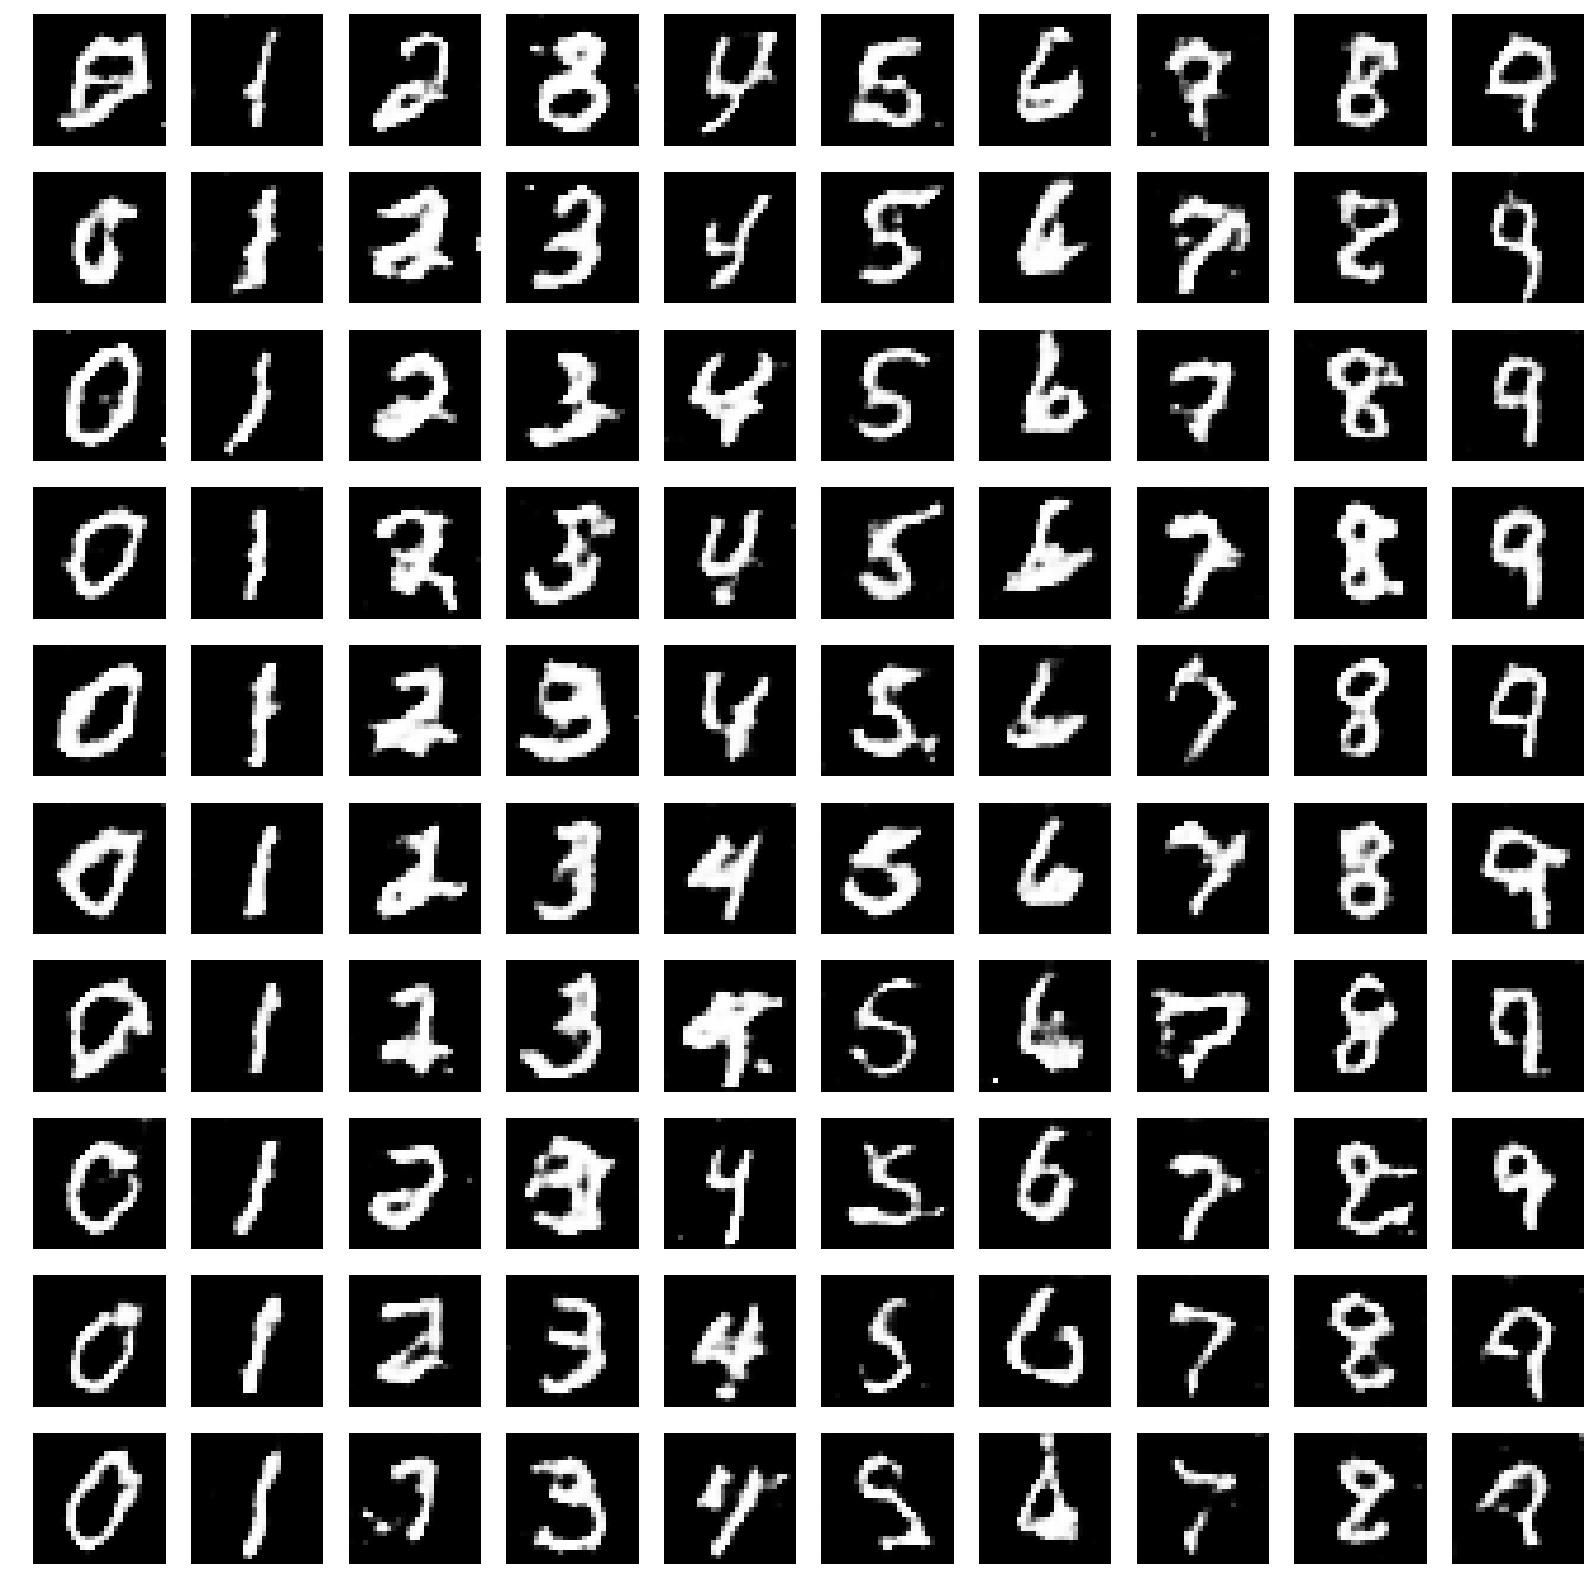

In [ ]:
for i in range(epoch_size):
    d_loss = []
    g_loss = []
    d_loss_category = []
    g_loss_category = []
    
    count = int(np.ceil(mnist.train.num_examples / batch_size))
    for j in range(count):
        batch_train, batch_target = mnist.train.next_batch(batch_size)
        batch_train = batch_train.astype(np.float32) * 2 - 1
        
        batch_z_var = np.random.normal(0, 1, size=(len(batch_train), z_var)).astype(np.float32)
        batch_z_category = oh_encoder.transform(np.random.randint(0, 10, size=len(batch_train)))
        batch_z_weight = np.random.random(size=[len(batch_train), 2]) * 2 - 1
        
        batch_z = np.concatenate((batch_z_var, batch_z_category, batch_z_weight), axis=1)
        
        # Discriminator Train
        for _ in range(train_d_count):
            _, loss_d, loss_d_category, asdf = sess.run([Train_D, Loss_D, Loss_D_Category, X_Fake], \
                                 feed_dict={X_Real: batch_train, Y: batch_target, Z: batch_z})
            d_loss += [loss_d]
            d_loss_category += [loss_d_category]

        # Generator Train
        for _ in range(train_g_count):
            _, loss_g, loss_g_category = sess.run([Train_G, Loss_G, Loss_G_Category], \
                                 feed_dict={Z_var: batch_z_var, Z_category: batch_z_category, Z_weight: batch_z_weight})
            g_loss += [loss_g]
            g_loss_category += [loss_g_category]
            
    print('Epoch : %d, loss_d & category : %.4f & %.4f, loss_g & category : %.4f & %.4f' % \
          (i, np.mean(d_loss), np.mean(d_loss_category), np.mean(g_loss), np.mean(g_loss_category)))
    
    if i % display_epoch == 0:
        gen_mnist = sess.run(X_Fake, feed_dict={Z: z_sample})
        
        display.clear_output(wait=True)
        DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in np.reshape(gen_mnist, (-1, 784))], depth=10)
        display.display(plt.gcf())
        plt.close()